**Before starting:**

You need to install Basemap. Do it only once.

In [1]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


**Goal of this practice:**

In this third practice, we will use BigQuery and machine learning tools to perform some predictive statistics. We still use Google Colab to run this Jupyter notebook and interact with the Google Cloud Platform. We will work on the whole database (1998-2015, 150Go).

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(10,10) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [3]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. using the following command. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

**Part 1)**

Model the daily mean SSH time series in the Red Sea, between longitudes (+32,+45) and latitudes (+13,+30). We suggest to use a linear tendancy and a one-year seasonal cycle such that: $SSH(t)=\alpha_0 + \alpha_1 t + \alpha_2 sin(2\pi\omega t) + \alpha_3 cos(2\pi\omega t)$, with $\omega=\frac{1}{365.25}$. 

This model can be adjusted (i.e., the $\alpha$ parameters can be estimated) using a multiple linear regression. We suggest to use the function *LinearRegression()* from *sklearn.linear_model*.

In [36]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(ssh) AS ssh_mean, AVG(sst) AS sst_mean
FROM bdo2020.bdo2020.1998_2015
WHERE lon>32 AND lon<45 AND lat>13 AND lat<30
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
import numpy as np

In [37]:
omega = 1/365.25
t = output.time
ssh = output.ssh_mean
sst = output.sst_mean
x1 = np.sin(2 * np.pi * omega * t)
x2 = np.cos(2 * np.pi * omega * t)

In [38]:
from sklearn.linear_model import LinearRegression

In [45]:
X = np.vstack((t,x1,x2)).T
Y = np.vstack((ssh, sst)).T
model = LinearRegression()
model.fit(X,Y)

LinearRegression()

In [48]:
print('Model coefficients for [[a1, a2, a3] [a4, a5, a6]]: {}'.format(model.coef_))
print('Model coefficient for [b1, b2]: {}'.format(model.intercept_))

Model coefficients for [[a1, a2, a3] [a4, a5, a6]]: [[ 1.55211333e-05  5.24342892e-02  1.58397295e-01]
 [ 6.42004738e-06 -1.69565364e+00 -2.03317083e+00]]
Model coefficient for [b1, b2]: [-10.76734275  24.85177797]


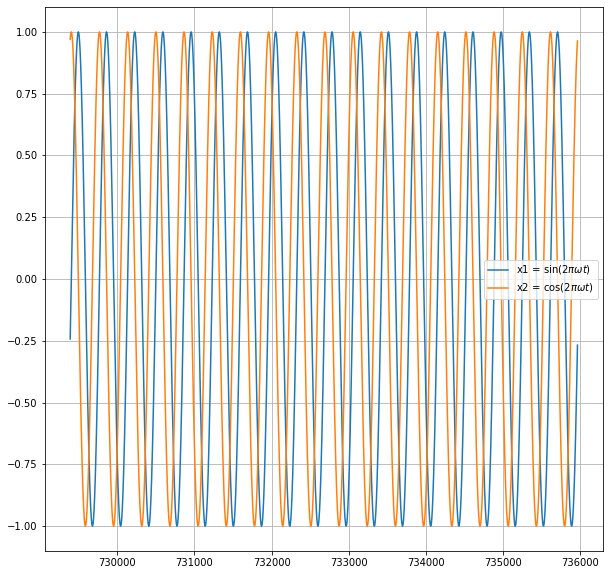

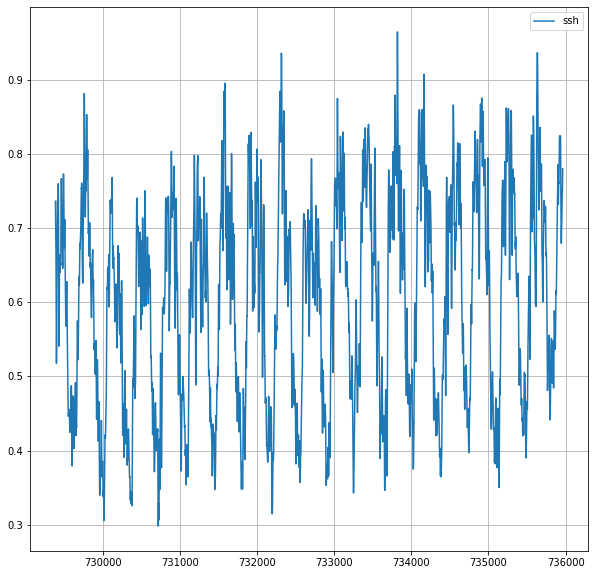

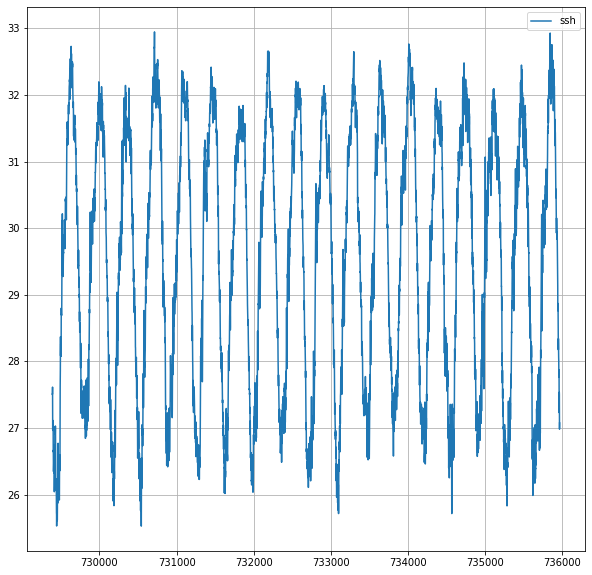

In [49]:
plt.figure()
p0 = plt.plot(t,x1,label=r'x1 = sin($2 \pi \omega t$)')
p1 = plt.plot(t,x2,label=r'x2 = cos($2 \pi \omega t$)')
plt.grid()
plt.legend()

plt.figure()
plt.plot(t,ssh,'-',label=r'ssh')
plt.grid()
plt.legend()

plt.figure()
plt.plot(t,sst,'-',label=r'ssh')
plt.grid()
plt.legend()

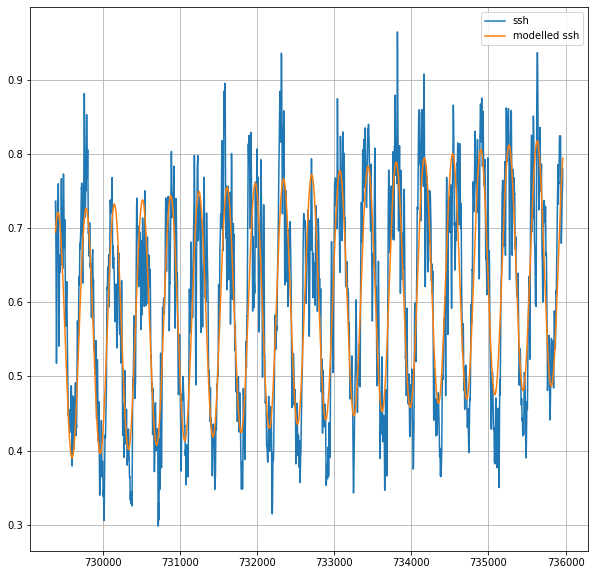

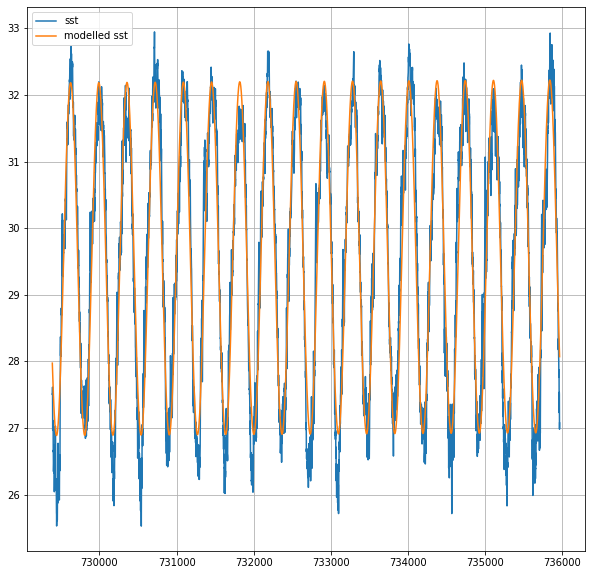

In [57]:
Y_hat = model.predict(X)

plt.figure()
plt.plot(t,ssh,label='ssh')
plt.plot(t,Y_hat[:,0],label='modelled ssh')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t,sst,label='sst')
plt.plot(t,Y_hat[:,1],label='modelled sst')
plt.legend()
plt.grid()

**Part 2)**

Model the relationships between SST and SSH in the Agulhas current, between longitude (+42,+46) and latitude (-40,-36), extracting a random sample of data (1%). We suggest to compare linear and nonlinear regressions (e.g., use the function *SVR()* from *sklearn.svm*).

To improve your statistical modelization, you can additionally use the latitude and/or time as regressors. Be careful when you manipulate time $t$ in Julian days, we have to decompose using $\sin(2\pi t/365.25)$ and $\cos(2\pi t/365.25)$.

In [58]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, time, sst, ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-40 AND lat<-36 AND lon>42 AND lon<46 AND RAND()<0.01

Query is running:   0%|          |

Downloading:   0%|          |

In [59]:
lon = output.lon
lat = output.lat
time = output.time
sst = output.sst
ssh = output.ssh

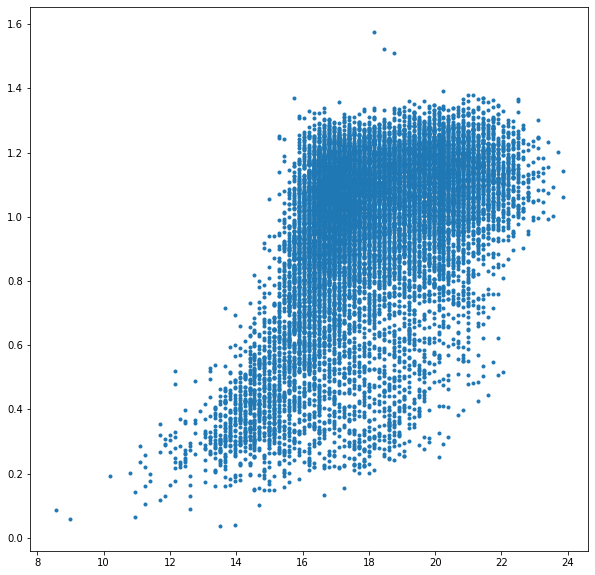

In [60]:
plt.plot(sst,ssh,'.')

In [64]:
X = np.vstack((sst))
Y = np.vstack((ssh))
model2 = LinearRegression()
model2.fit(X,Y)

LinearRegression()

In [66]:
print('Model coefficients for a: {}'.format(model2.coef_))
print('Model coefficient for b: {}'.format(model2.intercept_))

Model coefficients for a: [[0.06254578]]
Model coefficient for b: [-0.16275401]


In [67]:
Y_hat = model2.predict(X)

Text(0, 0.5, 'ssh')

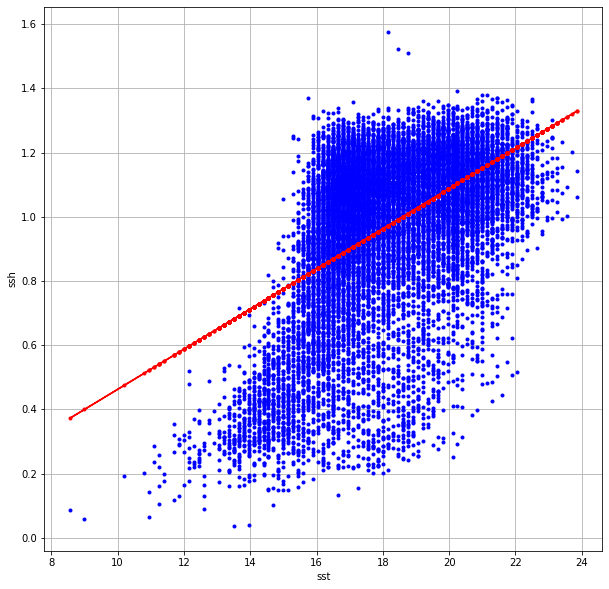

In [69]:
fig=plt.figure()
ax0=plt.subplot(111)
p0=plt.plot(sst,ssh,'b.')
p1=plt.plot(sst,Y_hat[:,0],'r.-')
plt.grid()
ax0.set_xlabel('sst')
ax0.set_ylabel('ssh')

In [70]:
from sklearn.svm import SVR

In [82]:
model3=SVR(C=500, epsilon=10)
model3.fit(X, Y)

SVR(C=500, epsilon=10)

In [83]:
Y_hat = model3.predict(X)

In [84]:
print(Y_hat)

[0.8063 0.8063 0.8063 ... 0.8063 0.8063 0.8063]


Text(0, 0.5, 'ssh')

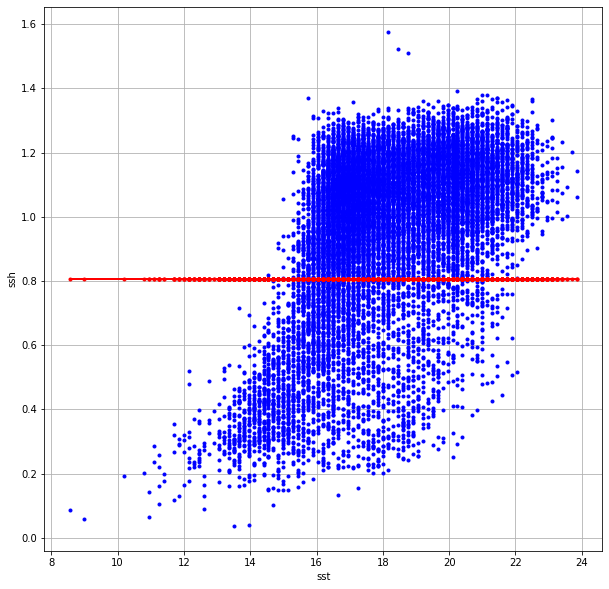

In [85]:
fig=plt.figure()
ax0=plt.subplot(111)
p0=plt.plot(sst,ssh,'b.')
p1=plt.plot(sst,Y_hat,'r.-')
plt.grid()
ax0.set_xlabel('sst')
ax0.set_ylabel('ssh')